In [ ]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import io
import matplotlib
from IPython.display import display
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
!gdown --id 1ti6QbZh_j9rh9fhKGZIoThM7FN9tF3Un #training data

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ti6QbZh_j9rh9fhKGZIoThM7FN9tF3Un
To: /content/labeled_data.csv
100% 2.57M/2.57M [00:00<00:00, 180MB/s]


In [ ]:
tweets = pd.read_csv('/content/final_dataset.txt')
tweets['Class'] = tweets['Class'].replace({'sexism': 0})
tweets['Class'] = tweets['Class'].replace({'none': 1})
tweets['Class'] = tweets['Class'].replace({'racism': 0})
dicti = { 'Class': 'class','Tweets': 'tweet'}
tweets.rename(columns=dicti,
          inplace=True)
display(tweets.head())
display(tweets.groupby("class").count())

,Tweet Id,tweet,User Id,Screen Name,class
0,319399851215433000,Oh yeah Colin! Smash those girls! :D #MKR,949380854,CreatrixKali,0
1,320817818222358000,It's insane they keep bringing people back. Wh...,297877558,quincepoacher,1
2,324114200450437000,@berkeley_eagle #MKR this shit show has more ...,272704749,MarkTramby,1
3,326286656854454000,*sigh* oh Colin 😍 #MKR,71416635,BinnyD,1
4,381988216292655000,"RT @brian_day15: I swear, I'm not sexist, but ...",930620467,YesYoureSexist,0


,Tweet Id,tweet,User Id,Screen Name
class,,,,
0,3009,3009,3009,3009
1,8316,8316,8316,8316


In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
nltk.download('punkt')
ps = PorterStemmer()
for i in range(len(tweets)):
  words = word_tokenize(tweets['tweet'][i])
  for j in range(len(words)):
    words[j] = ps.stem(words[j]) if words[j] not in set(all_stopwords) else ''
  tweets['tweet'][i] = ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
display(tweets.head())

,Tweet Id,tweet,User Id,Screen Name,class
0,319399851215433000,oh yeah colin ! smash girl ! : d # mkr,949380854,CreatrixKali,0
1,320817818222358000,it 's insan keep bring peopl back . when sh...,297877558,quincepoacher,1
2,324114200450437000,@ berkeley_eagl # mkr shit show comeback j...,272704749,MarkTramby,1
3,326286656854454000,* sigh * oh colin 😍 # mkr,71416635,BinnyD,1
4,381988216292655000,"rt @ brian_day15 : i swear , i 'm not sexist ,...",930620467,YesYoureSexist,0


In [ ]:
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "") # remove URL protocol with trailing whitespace
    df[text_field] = df[text_field].str.replace(r"http", "") # remove URL protocol
    df[text_field] = df[text_field].str.replace(r"@\S+", "") # remove at signs with leading spaces 
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\n]", " ") # remove non-alphanumerical
    df[text_field] = df[text_field].str.replace(r"@", "at") # replace at signs with "at"
    df[text_field] = df[text_field].str.replace(r'\b\w{1,3}\b', '') # replace at words
    df[text_field] = df[text_field].str.replace(r'[0-9]', '') # replace at words
    df[text_field] = df[text_field].str.lower() # convert all to lowercase
    # df[text_field] = df[text_field].apply(lambda x: ''.join([stemmer.stem(y) for y in x]))
    return df

In [ ]:
# from nltk.stem import PorterStemmer
# from nltk.tokenize import word_tokenize
# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# lemmatizer = nltk.stem.WordNetLemmatizer()
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# ps = PorterStemmer()
# def cleann(df,text_field):
#   df[text_field] = df[text_field].apply(lambda x: ''.join([ps.stem(y) for y in x]))
#   # xp = pd.DataFrame(df[text_field], columns=[text_field])
#   # df[text_field] = xp.text_field.apply([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text_field)])
#   return df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# function to transform tweets to vectorized bag of word embedding
def vectorizer(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

# set of all tweet text
# list_corpus = tweets["tweet"]
list_corpus = tweets[['class', 'tweet']]
# set of all tweet class labels
list_labels = tweets["class"].tolist()

# split into 80/20 train/test 
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=69)

X_train = clean_text(X_train, "tweet")
# print(X_train)
# # X_train = cleann(X_train,'tweet')
# print(X_train)

# convert training and test set word to bag of words vectorized representation
X_train_counts, count_vectorizer = vectorizer(X_train['tweet'])
X_test_counts = count_vectorizer.transform(X_test['tweet'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
from sklearn.linear_model import LogisticRegression

# define logistic regression model 
clf = LogisticRegression()

# fit model on training data
clf.fit(X_train_counts, y_train)

# get model predictions on bag of words vectorized test data
y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred_np = clf.predict(X_test_counts)
cm = confusion_matrix(y_test, y_pred_np)
print(classification_report(y_test,y_pred_np))

              precision    recall  f1-score   support

           0       0.83      0.58      0.68       631
           1       0.85      0.95      0.90      1634

    accuracy                           0.85      2265
   macro avg       0.84      0.77      0.79      2265
weighted avg       0.85      0.85      0.84      2265



In [ ]:
def get_most_important_features(vectorizer, coefficients, n=20):
    
    # convert index of word from vectorizer into the word 
    index_to_word = {index:word for word,index in count_vectorizer.vocabulary_.items()}
    
    # assign coefficient to word by matching the index of the coefficient and word
    word_importances = [(coef, index_to_word[index]) for index, coef in enumerate(clf.coef_[0])]
    sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
    # n = len(word_importances)//2
    # print(word_importances)
    p = []
    n = 0
    for x,y in sorted_coeff:
      if(x>=0):
        n+=1
      p.append(y)
    print(p)
    print(n)
    top = sorted(sorted_coeff[:20], key = lambda x : x)
    print(sorted_coeff[:n])
    print([y for x,y in sorted_coeff[:n]])
    print(len(set(word_importances)))
    bottom = sorted_coeff[-20:]
    print(sorted_coeff[n:])
    p= [y for x,y in sorted_coeff[n:]]
    print(p[::-1])
    print(len(p))
    classes = {
        'top':top,
        'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf.coef_)

['freebsdgirl', 'whoa', 'wadhwa', 'lennyfinnegan', 'statement', 'lemon', 'ohsosoftley', 'thequinnspiraci', 'howev', 'disappoint', 'femfreq', 'spacekatg', 'mandatori', 'code', 'chriswarcraft', 'dylanw', 'weird', 'approv', 'bullshit', 'stopwadhwa', 'experi', 'harass', 'email', 'random', 'alli', 'bacon', 'toward', 'pancak', 'vicki', 'aarondagloria', 'girlziplock', 'parrot', 'emili', 'upset', 'here', 'meet', 'chang', 'peerwork', 'freebsd', 'saddest', 'book', 'uber', 'amaz', 'tweet', 'rianleari', 'skin', 'gater', 'jameswebb', 'tcsngspm', 'ebook', 'randi', 'whatev', 'everyth', 'feel', 'round', 'brettjglasco', 'dpckgqwpqx', 'channel', 'bbilco', 'public', 'larg', 'posit', 'gozlem', 'meal', 'sfthewolf', 'switchmanzzz', 'sschink', 'belikenanana', 'happi', 'robert', 'colonelkickhead', 'critiqu', 'impact', 'because', 'target', 'instant', 'shitti', 'tech', 'compani', 'contest', 'glad', 'survey', 'those', 'asshol', 'danger', 'kirindav', 'shoot', 'becom', 'print', 'coffe', 'tomorrow', 'ballsohard', '

In [ ]:
# for x in importance['bottom']:
#   print(x)

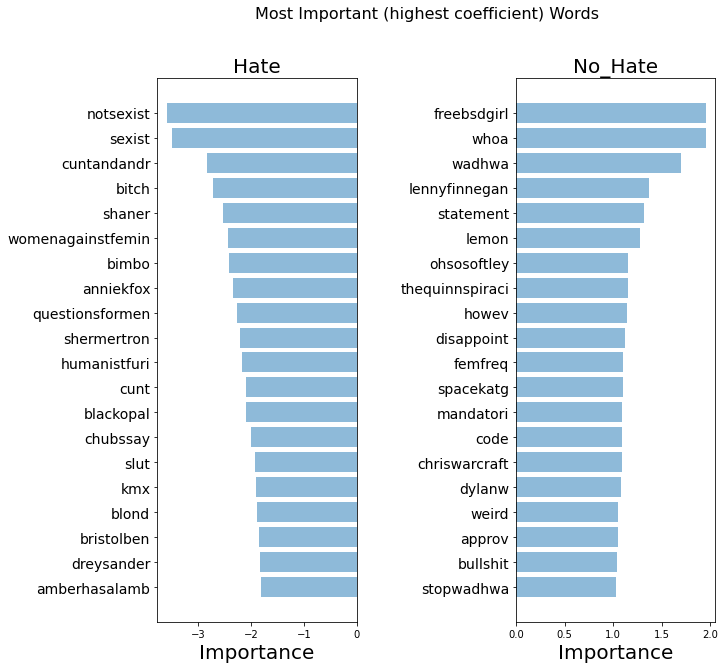

In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, title):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  
    
    # plot words with most negative coefficients (irrelevant words)
    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Hate', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    #plt.xlim(-8,0)
    
    # plot words with highest coefficients (relevant/disaster words)
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('No_Hate', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(title, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    #plt.xlim(0,8)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [word_score[0] for word_score in importance['top']]
top_words = [word_score[1] for word_score in importance['top']]
bottom_scores = [word_score[0] for word_score in importance['bottom']]
bottom_words = [word_score[1] for word_score in importance['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important (highest coefficient) Words")